In [1]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
import cPickle as pickle
import data_generator as dg
import multiscale_detect as md
import kmeansutil as ku
import non_maximum_suppression as nms
import utils as ut
%matplotlib inline  

Get data array from generate_data module. Randomize the array. Pick sample_size amount from each

Data is stored in a pickled zipped list of features and labels

In [2]:
#get positive images, determine best ratios (rows over columns), assign to images

pimages = dg.getImagesFromJSON(open("labels.json").read())
clusters, images = ku.addClusterLabels(pimages)
ratios = [r[0] for r in clusters]
print ratios

[0.77338458477358618, 1.1003667227651768, 0.46285263035703317]


Separate positive images into aspect ratios, get negative images and crop to aspect ratios

In [3]:
pratio0imgs = []
pratio1imgs = []
pratio2imgs = []

for image in images:
    if image[1] == 0:
        pratio0imgs.append(image[0])
    elif image[1] == 1:
        pratio1imgs.append(image[0])
    elif image[1] == 2:
        pratio2imgs.append(image[0])

print "Number pos imgs at ratio 0: ", len(pratio0imgs)
print "Number pos imgs at ratio 1: ", len(pratio1imgs)
print "Number pos imgs at ratio 2: ", len(pratio2imgs)
print

print "pratio0 average ratio:", sum([float(x.shape[0])/(x.shape[1]+1) for x in pratio0imgs])/len(pratio0imgs)
print "pratio1 average ratio:", sum([float(x.shape[0])/(x.shape[1]+1) for x in pratio1imgs])/len(pratio1imgs)
print "pratio2 average ratio:", sum([float(x.shape[0])/(x.shape[1]+1) for x in pratio2imgs])/len(pratio2imgs)
print
        
#get negative images, use ratios found for positive images to match
nimages = dg.getRandomMultiple("sun_images", 200, 0)
partialsignimgs = dg.getRandomMultiple("partial", 200, 0)
nimages = nimages+partialsignimgs
print len(nimages)
   
nratio0imgs = [dg.cropToRatio(x, ratios[0]) for x in nimages]
nratio1imgs = [dg.cropToRatio(x, ratios[1]) for x in nimages]
nratio2imgs = [dg.cropToRatio(x, ratios[2]) for x in nimages]


print "Number neg imgs at ratio 0:", len(nratio0imgs)
print "Number neg imgs at ratio 1:", len(nratio1imgs)
print "Number neg imgs at ratio 2:", len(nratio2imgs)


Number pos imgs at ratio 0:  140
Number pos imgs at ratio 1:  53
Number pos imgs at ratio 2:  77

pratio0 average ratio: 0.773384584774
pratio1 average ratio: 1.10036672277
pratio2 average ratio: 0.462852630357

400
Number neg imgs at ratio 0: 400
Number neg imgs at ratio 1: 400
Number neg imgs at ratio 2: 400


Generate features from HOGs and images for each label and aspect ratio

In [4]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data


In [5]:
minDim = 80
HOGs, dims = dg.ratiosToHOGS(ratios, minDim)
print dims


[(56, 80), (88, 80), (32, 80)]


In [6]:
pdata0ratio = getFeaturesWithLabel(pratio0imgs, HOGs[0], dims[0], 1)
pdata1ratio = getFeaturesWithLabel(pratio1imgs, HOGs[1], dims[1], 1)
pdata2ratio = getFeaturesWithLabel(pratio2imgs, HOGs[2], dims[2], 1)

ndata0ratio = getFeaturesWithLabel(nratio0imgs, HOGs[0], dims[0], 0)
ndata1ratio = getFeaturesWithLabel(nratio1imgs, HOGs[1], dims[1], 0)
ndata2ratio = getFeaturesWithLabel(nratio2imgs, HOGs[2], dims[2], 0)

data0ratio = pdata0ratio + ndata0ratio
data1ratio = pdata1ratio + ndata1ratio
data2ratio = pdata2ratio + ndata2ratio

shuffle(data0ratio)
shuffle(data1ratio)
shuffle(data2ratio)

feat0, label0 = map(list, zip(*data0ratio))
feat1, label1 = map(list, zip(*data1ratio))
feat2, label2 = map(list, zip(*data2ratio))

feat0 = [x.flatten() for x in feat0]
feat1 = [x.flatten() for x in feat1]
feat2 = [x.flatten() for x in feat2]

sample_size0 = len(feat0)
sample_size1 = len(feat1)
sample_size2 = len(feat2)

train_size0 = int(round(.8*sample_size0))
train_size1 = int(round(.8*sample_size1))
train_size2 = int(round(.8*sample_size2))



In [7]:
train_feat0 = np.array(feat0[:train_size0], np.float32)
test_feat0 = np.array(feat0[train_size0: sample_size0], np.float32)
train_label0 = np.array(label0[:train_size0])
test_label0 = np.array(label0[train_size0:sample_size0])

train_feat1 = np.array(feat1[:train_size1], np.float32)
test_feat1 = np.array(feat1[train_size1: sample_size1], np.float32)
train_label1 = np.array(label1[:train_size1])
test_label1 = np.array(label1[train_size1:sample_size1])

train_feat2 = np.array(feat2[:train_size2], np.float32)
test_feat2 = np.array(feat2[train_size2: sample_size2], np.float32)
train_label2 = np.array(label2[:train_size2])
test_label2 = np.array(label2[train_size2:sample_size2])

Train SVM

In [8]:
lsvm0 = svm.SVC(gamma=5, C=.1, kernel="linear")
lsvm0.fit(train_feat0, train_label0)

lsvm1 = svm.SVC(gamma=5, C=.1, kernel="linear")
lsvm1.fit(train_feat1, train_label1)

lsvm2 = svm.SVC(gamma=5, C=.1, kernel="linear")
lsvm2.fit(train_feat2, train_label2)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Compute and display training accuracy

In [9]:
print lsvm0.score(train_feat0, train_label0)
print lsvm1.score(train_feat1, train_label1)
print lsvm2.score(train_feat2, train_label2)

0.99537037037
0.997237569061
0.992146596859


Compute and display test set accuracy, true and false positives, true and false negatives, list of files that were misclassified

In [10]:
#compute test accuracy
result0 = lsvm0.predict(test_feat0)
result1 = lsvm1.predict(test_feat1)
result2 = lsvm2.predict(test_feat2)

print "test accuracy aspect ratio 0", lsvm0.score(test_feat0, test_label0)
print "test accuracy aspect ratio 1", lsvm1.score(test_feat1, test_label1)
print "test accuracy aspect ratio 2", lsvm2.score(test_feat2, test_label2)

print
print "first aspect ratio:"
ut.printConfusionMatrix(result0, test_label0)

print "second aspect ratio:"
ut.printConfusionMatrix(result1, test_label1)

print "third aspect ratio:"
ut.printConfusionMatrix(result2, test_label2)


test accuracy aspect ratio 0 0.981481481481
test accuracy aspect ratio 1 0.967032967033
test accuracy aspect ratio 2 0.968421052632

first aspect ratio:
true pos: 24 true neg: 82 false pos: 1 false neg: 1 

second aspect ratio:
true pos: 10 true neg: 78 false pos: 1 false neg: 2 

third aspect ratio:
true pos: 14 true neg: 78 false pos: 3 false neg: 0 



In [11]:
def getHardNegativeFeatures(lsvm, hog, imgDir, step=10, scale=1.1):
    #get dataset of negative images to scan through
    negFiles = dg.getAllFiles(imgDir)
    negImgs = []
    falsePos_feat = []
    signs = 0
    nosigns = 0

    for f in negFiles:
        negImgs.append([f, cv2.imread(imgDir + "/" + f)])
    
    if len(negImgs) == 0:
        raise "No images found"

    #multiscale detect
    counter = 1
    for row in negImgs:
        scales = md.pyramid(row[1], scale, minSize=(30, 30))
        winw = hog.winSize[1]
        winh = hog.winSize[0]

        for img in scales:
            results = []

            for (x, y, window) in md.sliding_window(img, step, (winw, winh)):        
                if window.shape[0] != winh or window.shape[1] != winw:
                    continue
                window = cv2.resize(window, (winh, winw))
                feat = hog.compute(window)
                result = lsvm.predict(feat.reshape(1,-1))[0]
                if result == 1:  
                    falsePos_feat.append(feat)
                    signs +=1
                else:
                    nosigns+=1
        counter +=1

    falsePosFeat = [x.flatten() for x in falsePos_feat] 
    return falsePosFeat

In [12]:
hardNeg0 = getHardNegativeFeatures(lsvm0, HOGs[0], "hwy_empty", step=40, scale=1.5)
hardNeg1 = getHardNegativeFeatures(lsvm1, HOGs[1], "hwy_empty", step=40, scale=1.5)
hardNeg2 = getHardNegativeFeatures(lsvm2, HOGs[2], "hwy_empty", step=40, scale=1.5)

print "number of false positives for classifiers", len(hardNeg0), len(hardNeg1), len(hardNeg2)

number of false positives for classifiers 149 3 138


In [13]:
#retrain classifiers
hNLabels0 = [0] * len(hardNeg0)
hNLabels1 = [0] * len(hardNeg1)
hNLabels2 = [0] * len(hardNeg2)

if hardNeg0:
    train_features_wfp0 = np.r_[train_feat0, np.array(hardNeg0)]
    train_labels_wfp0 = np.r_[train_label0, np.array(hNLabels0)]
    lsvm0.fit(train_features_wfp0, train_labels_wfp0)
    print "retraining accuracy for ratio 0", lsvm0.score(train_features_wfp0, train_labels_wfp0)
    result0 = lsvm0.predict(test_feat0)
    print "retrain test accuracy aspect ratio 0", lsvm0.score(test_feat0, test_label0)
    print "retrain first aspect ratio:"
    ut.printConfusionMatrix(result0, test_label0)

if hardNeg1:
    train_features_wfp1 = np.r_[train_feat1, np.array(hardNeg1)]
    train_labels_wfp1 = np.r_[train_label1, np.array(hNLabels1)]
    lsvm1.fit(train_features_wfp1, train_labels_wfp1)
    print "retraining accuracy for ratio 1",lsvm1.score(train_features_wfp1, train_labels_wfp1)
    result1 = lsvm1.predict(test_feat1)
    print "retrain test accuracy aspect ratio 1", lsvm1.score(test_feat1, test_label1)
    print "retrain second aspect ratio:"
    ut.printConfusionMatrix(result1, test_label1)
    
if hardNeg2:
    train_features_wfp2 = np.r_[train_feat2, np.array(hardNeg2)]
    train_labels_wfp2= np.r_[train_label2, np.array(hNLabels2)]
    lsvm2.fit(train_features_wfp2, train_labels_wfp2)
    print "retraining accuracy for ratio 2", lsvm2.score(train_features_wfp2, train_labels_wfp2)
    result2 = lsvm2.predict(test_feat2)
    print "retrain test accuracy aspect ratio 2", lsvm2.score(test_feat2, test_label2)
    print "retrain third aspect ratio:"
    ut.printConfusionMatrix(result2, test_label2)




retraining accuracy for ratio 0 0.993115318417
retrain test accuracy aspect ratio 0 0.972222222222
retrain first aspect ratio:
true pos: 23 true neg: 82 false pos: 1 false neg: 2 

retraining accuracy for ratio 1 0.997260273973
retrain test accuracy aspect ratio 1 0.956043956044
retrain second aspect ratio:
true pos: 9 true neg: 78 false pos: 1 false neg: 3 

retraining accuracy for ratio 2 0.975
retrain test accuracy aspect ratio 2 0.978947368421
retrain third aspect ratio:
true pos: 13 true neg: 80 false pos: 1 false neg: 1 



Find and display signs in a test image

In [14]:
def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), x[2] , int(x[3]*factor), int(x[4]*factor)] for x in boxes]

def findSigns(image, hog, lsvm, step=40, scale=1.1, minsize=(20,20)):
    if image is None:
        raise "No image to scan"
    
    winw = hog.winSize[1]
    winh = hog.winSize[0]

    scales = md.pyramid(image, scale, minsize)
    scaled_results = []

    for i, img in enumerate(scales):
        results = []

        for (x, y, window) in md.sliding_window(img, step, (winw, winh)):  
            if window.shape[0] != winh or window.shape[1] != winw:
                continue
            window = cv2.resize(window, hog.winSize)
            feat = hog.compute(window)
            result = lsvm.predict(feat.reshape(1,-1))[0]
        
            if result == 1:
                conf = lsvm.decision_function(feat.reshape(1,-1))[0]
                prediction = [x, y, conf, winw, winh]
                results.append(prediction)
        if not results:
            continue
        factor = float(image.shape[0])/img.shape[0]   
        scaled = transform_scale(factor, results)
        scaled_results.extend(scaled)
        
    return scaled_results


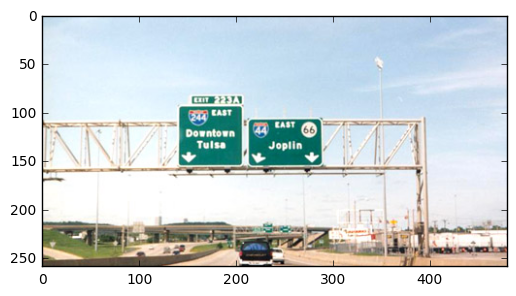

In [15]:
image = cv2.imread("multiscale_test/193.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
span = 2
scaled_results0 = findSigns(image, HOGs[0], lsvm0, step=span, scale=1.5)
scaled_results1 = findSigns(image, HOGs[1], lsvm1, step=span,scale=1.5)
scaled_results2 = findSigns(image, HOGs[2], lsvm2, step=span,scale=1.5)
results = scaled_results0 + scaled_results1 + scaled_results2

In [17]:
print len(results)
signs = [x for x in results if x[2]>.7]
print len(signs)
signs = nms.nms(signs, 1)

132
12


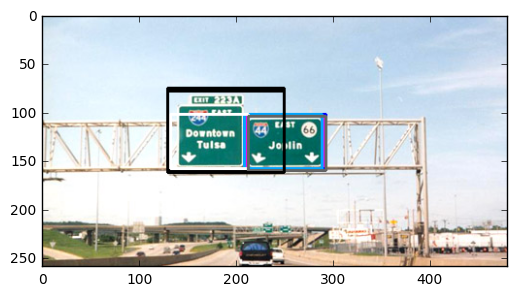

In [18]:
clone = image.copy()

for i, result in enumerate(signs):
    x1 = result[0]
    y1 = result[1]
    c = result[2]
    x2 = result[3] + x1
    y2 = result[4] + y1
        
    colors = [(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (100, 100, 100), (0, 0, 0)]
    cv2.rectangle(clone, (x1, y1), (x2, y2), colors[i%7], 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()